# Asteroid Minerals Analysis

## Introduction
In this notebook, we gain insights from 2 distinct datasets containing the quantities of different asteroids' mineral components measured in micrograms. Overall, there are 2 tasks to be fulfilled in the following analysis:
- Identify distinct types of asteroid via clustering instances into groups
- Infer mechanically stable asteroids from their mineral decompositions via training binary classification models

For each task, we went through the process of firstly preprocessing the data, then selecting suitable algorithms and building the models, and finally comparing and summarizing the results.

## Task 1 -- Detect different types of asteroids

### Load and Clean Data

In [1]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('China Aug 2022 Asteroid 1.csv') #read the dataset
df1.head()

,ID,Alamosite,Chalcophyllite,Gypsum,Orpiment,Junitoite,Phoenicochroite,Groutite,Zykaite,Weloganite,Diadochite,Semseyite,Creedite,Xieite,Eveite,Rutile,Tyrolite,Feroxyhyte,Kostovite
0,Ast_000001,1893,3812,4945,4139,2689,3768,9569,3164,4259,2396,4239,12622,2955,5695,3161,3115,3356,3309
1,Ast_000002,3604,4652,2587,2021,4569,1844,16390,1598,3981,5562,2426,6278,4205,3471,1100,2433,3845,1607
2,Ast_000003,4370,4676,2648,2375,4468,1037,19471,1495,3981,5267,1924,7317,3366,2485,1598,2313,3802,1905
3,Ast_000004,2767,5068,1547,2958,3945,2363,13061,4045,3327,3581,2042,9063,5112,2422,4076,4758,4329,2643
4,Ast_000005,2007,4186,3776,3177,3575,2242,10044,3059,4721,2719,4707,9740,4266,3564,1595,2919,1938,4296


In [3]:
#ID is useless for model
df1 = df1.drop(labels = 'ID',axis=1)
#Look for data types
df1.dtypes

Alamosite          object
Chalcophyllite     object
Gypsum             object
Orpiment           object
Junitoite          object
Phoenicochroite    object
Groutite           object
Zykaite            object
Weloganite         object
Diadochite         object
Semseyite          object
Creedite           object
Xieite             object
Eveite             object
Rutile             object
Tyrolite           object
Feroxyhyte         object
Kostovite          object
dtype: object

In [4]:
#Convert to numerical value
#‘coerce’means invalid parsing(eg.str) will be set as NaN.
df1 = df1.apply(pd.to_numeric, downcast='float', errors='coerce')

In [5]:
#Number of NaNs in each column
df1.isnull().sum(axis=0)

Alamosite           7
Chalcophyllite     11
Gypsum              6
Orpiment           11
Junitoite          10
Phoenicochroite    12
Groutite           14
Zykaite            11
Weloganite          3
Diadochite          8
Semseyite           8
Creedite           21
Xieite              9
Eveite              7
Rutile              4
Tyrolite            8
Feroxyhyte         11
Kostovite          11
dtype: int64

Before imputing missing data, we need to make sure that there are no anomalous instances in the data. However, from the summary table below, we can find that there are some extremely large outliers. Hence, we need to firstly deal with those uninformative records.

In [6]:
df1.astype('float')
df1.describe()

,Alamosite,Chalcophyllite,Gypsum,Orpiment,Junitoite,Phoenicochroite,Groutite,Zykaite,Weloganite,Diadochite,Semseyite,Creedite,Xieite,Eveite,Rutile,Tyrolite,Feroxyhyte,Kostovite
count,4.959000e+03,4.955000e+03,4.960000e+03,4.955000e+03,4.956000e+03,4.954000e+03,4.952000e+03,4.955000e+03,4.963000e+03,4.958000e+03,4.958000e+03,4.945000e+03,4.957000e+03,4.959000e+03,4.962000e+03,4.958000e+03,4.955000e+03,4.955000e+03
mean,4.073012e+03,6.011100e+03,4.191899e+03,4.557989e+03,4.880845e+03,3.616938e+03,1.889351e+04,4.705613e+03,4.696166e+03,4.085625e+03,3.633448e+03,1.468136e+04,4.126971e+03,4.716552e+03,5.472356e+03,4.292445e+03,4.317895e+03,3.671523e+03
std,2.453312e+04,1.265846e+05,3.469010e+04,3.746493e+04,3.467166e+04,2.835929e+04,1.011310e+05,3.746614e+04,3.465620e+04,2.453975e+04,2.004447e+04,1.159511e+05,2.003249e+04,3.467322e+04,1.122313e+05,3.165717e+04,2.833279e+04,2.454419e+04
min,1.002000e+03,4.130000e+02,6.260000e+02,5.600000e+01,8.700000e+01,4.000000e+00,6.005000e+03,6.350000e+02,6.110000e+02,1.094000e+03,1.454000e+03,3.660000e+02,1.520000e+03,1.085000e+03,5.730000e+02,1.762000e+03,7.600000e+02,5.350000e+02
25%,2.448500e+03,2.408500e+03,1.897000e+03,2.432000e+03,2.942250e+03,2.160000e+03,1.179450e+04,2.176000e+03,2.854000e+03,2.562250e+03,2.355250e+03,7.493000e+03,2.947000e+03,2.478000e+03,1.835000e+03,2.714000e+03,2.702000e+03,2.651500e+03
50%,3.885000e+03,4.060000e+03,2.548000e+03,3.165000e+03,3.967000e+03,2.686000e+03,1.754350e+04,3.671000e+03,3.641000e+03,3.133000e+03,3.133000e+03,9.700000e+03,3.898000e+03,3.098000e+03,2.360000e+03,3.109000e+03,3.438000e+03,3.099000e+03
75%,4.341500e+03,4.602500e+03,4.185000e+03,3.778500e+03,4.384000e+03,3.574000e+03,1.937500e+04,4.317000e+03,4.270000e+03,4.489000e+03,4.130750e+03,1.153900e+04,4.395000e+03,4.713500e+03,3.240750e+03,3.906500e+03,4.489500e+03,3.657000e+03
max,1.000216e+06,8.745635e+06,1.000292e+06,1.000295e+06,1.000236e+06,1.000245e+06,4.002886e+06,1.000300e+06,1.000297e+06,1.000290e+06,1.000266e+06,3.001084e+06,1.000218e+06,1.000258e+06,7.456354e+06,1.000293e+06,1.000292e+06,1.000299e+06


In [7]:
#Look at outliers
outliers = pd.DataFrame(columns = df1.columns)
for column in df1.columns:
    #values larger than mean + 3* standard deviation
    outliers = pd.concat([df1[df1[column] > np.mean(df1[column])+3 * np.std(df1[column])],outliers])
outliers

,Alamosite,Chalcophyllite,Gypsum,Orpiment,Junitoite,Phoenicochroite,Groutite,Zykaite,Weloganite,Diadochite,Semseyite,Creedite,Xieite,Eveite,Rutile,Tyrolite,Feroxyhyte,Kostovite
58,3990.000,1.636000e+03,2400.0,4019.0,1463.0,3721.0,17970.0,1866.0,4064.0,2195.0,3250.0,12256.0,2544.0,4700.0,2352.0,3187.0,2584.0,1.000264e+06
3144,4358.000,1.662000e+03,2171.0,4101.0,1790.0,3540.0,19439.0,1888.0,3970.0,2449.0,2725.0,12499.0,2193.0,4461.0,2569.0,3668.0,3131.0,1.000221e+06
4903,4845.000,1.719000e+03,2550.0,2598.0,4222.0,3227.0,21388.0,2954.0,2410.0,4786.0,4078.0,8005.0,4553.0,2562.0,2030.0,2980.0,4697.0,1.000299e+06
1550,4065.000,4.759000e+03,1936.0,2368.0,4791.0,1696.0,18269.0,2783.0,3844.0,4362.0,1909.0,7307.0,3985.0,3026.0,1966.0,2282.0,1000291.5,1.234000e+03
1615,2464.000,3.967000e+03,4289.0,3891.0,2563.0,3148.0,11858.0,4287.0,3158.0,2721.0,4643.0,11875.0,3358.0,4631.0,3562.0,3212.0,1000267.0,3.059000e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3933,4274.000,1.000281e+06,1681.0,3400.0,3976.0,3687.0,19088.0,4243.0,2437.0,4420.0,3675.0,10395.0,4489.0,2449.0,1799.0,3332.0,5190.0,3.924000e+03
4375,3935.000,8.745635e+06,1963.0,4586.0,1894.0,3515.0,17734.0,2020.0,3814.0,1971.0,3132.0,13979.0,3216.0,4277.0,2957.0,3665.0,2868.0,3.773000e+03
137,1000216.250,2.052000e+03,1926.0,3120.0,4383.0,4180.0,4002886.0,3839.0,2343.0,4328.0,3745.0,9568.0,4677.0,2819.0,1404.0,2813.0,4951.0,3.341000e+03
1763,1000210.250,4.882000e+03,4743.0,1821.0,4169.0,2175.0,4002845.0,4241.0,1928.0,2393.0,2467.0,5671.0,2871.0,3719.0,2521.0,3916.0,3520.0,2.694000e+03


Closer inspection on the outliers shows that other than the extremely large feature value in each instance, other feature values are mostly non-problematic. Based on that finding, we first replace outlier values with NaNs, then filling all the NaNs using **KNN** (K nearest neighbors) imputer (documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html).

In [8]:
#replace outliers with NaN
for column in df1.columns:
    #values larger than mean + 3* standard deviation
    outliers_index = df1[df1[column] > np.mean(df1[column])+3 * np.std(df1[column])].index
    df1.loc[outliers_index,column] = np.nan

In [9]:
#There is still one large outier in Phoenicochroite
df1.sort_values(by=["Phoenicochroite"], ascending=[False]).head()

,Alamosite,Chalcophyllite,Gypsum,Orpiment,Junitoite,Phoenicochroite,Groutite,Zykaite,Weloganite,Diadochite,Semseyite,Creedite,Xieite,Eveite,Rutile,Tyrolite,Feroxyhyte,Kostovite
1739,3956.0,1829.0,1832.0,4426.0,1734.0,63545.0,17815.0,1938.0,3436.0,2959.0,3611.0,13477.0,2600.0,4445.0,2261.0,3547.0,3069.0,3502.0
3315,4423.0,1920.0,1740.0,3033.0,4084.0,4867.0,19703.0,3861.0,3265.0,5499.0,3940.0,9301.0,5590.0,2807.0,1717.0,2617.0,4985.0,3397.0
158,5082.0,3146.0,1788.0,2844.0,4038.0,4792.0,22327.0,3949.0,2197.0,5754.0,3513.0,8732.0,5075.0,2538.0,2903.0,2453.0,4712.0,4321.0
1609,4159.0,2459.0,2012.0,3184.0,4098.0,4772.0,18641.0,4243.0,3076.0,4967.0,3978.0,9754.0,4714.0,2281.0,1129.0,2761.0,4812.0,2852.0
3990,4125.0,2017.0,2124.0,3020.0,4295.0,4738.0,18499.0,4370.0,2924.0,4370.0,3776.0,9264.0,4921.0,2741.0,1731.0,3018.0,4800.0,3631.0


In [10]:
df1.loc[1739,"Phoenicochroite"] = np.nan

In [11]:
#Number of NaNs in each column
df1.isnull().sum(axis=0)

Alamosite          10
Chalcophyllite     15
Gypsum             12
Orpiment           18
Junitoite          16
Phoenicochroite    17
Groutite           20
Zykaite            18
Weloganite          9
Diadochite         11
Semseyite          10
Creedite           32
Xieite             11
Eveite             13
Rutile             12
Tyrolite           13
Feroxyhyte         15
Kostovite          14
dtype: int64

<AxesSubplot:>

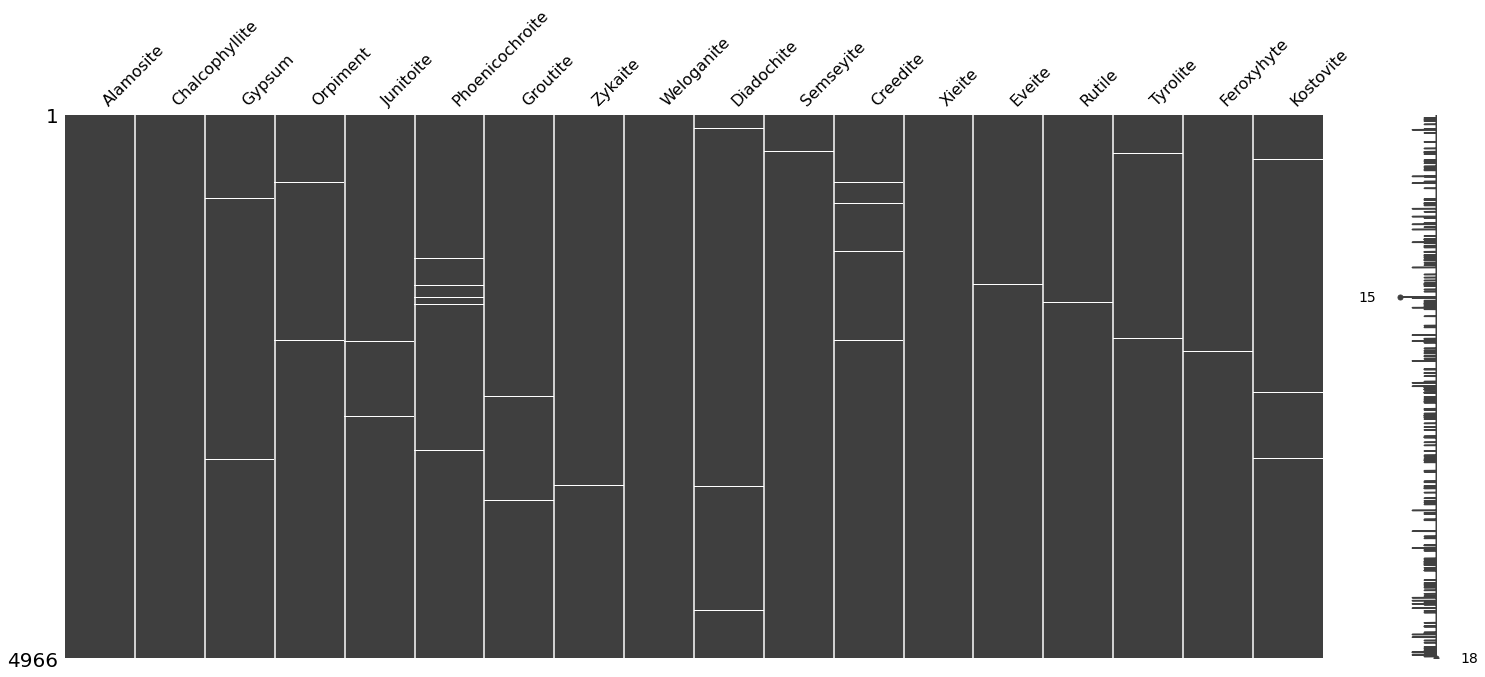

In [12]:
#Visualize missing values
import missingno as msno
msno.matrix(df1)

In [13]:
#impute NaNs using KNN with 3 neighbors
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3) #using 3 most similar data points
df1 = pd.DataFrame(imputer.fit_transform(df1),columns = df1.columns)

In [14]:
df1.isnull().sum().sum() #no more missing values

0

Then, we try to do some exploratory data analysis investigating potential relationship between features and the number and shape of the clusters

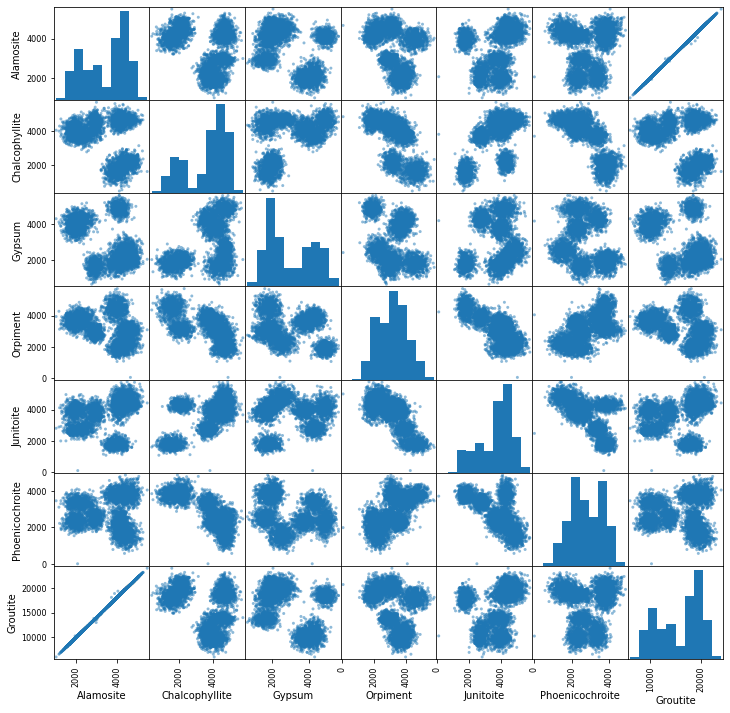

In [15]:
#pairplot for first 8 features
from pandas.plotting import scatter_matrix
scatter_matrix(df1.iloc[:,0:7:1],figsize=(12,12))
plt.show()

(18.5, -0.5)

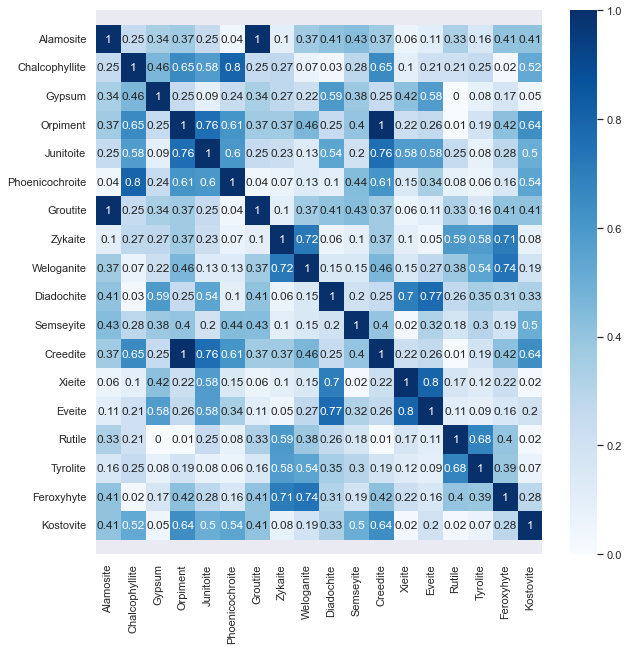

In [16]:
#correlation
correlation_matrix = np.absolute(df1.corr().round(2))
sns.set(rc={'figure.figsize':(10,10)})
ax = sns.heatmap(correlation_matrix,annot=True, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

From the pairwise scatterplot, we can get some hints for the fact that there are some groups of asteroids that are similar in mineral compositions. It is also worth noticing that Alamosite and Groutite, Orpiment and Creedite are highly linearly correlated, so it is inproper to include both of them to build the modes.

From the correlation heatmap, the majority of the features are inter-correlated with one another, so we can apply **dimensionality reduction** techniques to compress the data, reduce noise and make it easier to handle.

### Principle Component Analysis

array([0.5277897 , 0.75366783, 0.84982646, 0.91734517, 0.95208806,
       0.96503633, 0.97456014, 0.9785737 , 0.98169094, 0.9847675 ,
       0.98757064, 0.9902413 , 0.99276507, 0.9952539 , 0.99766254,
       0.99999547, 0.99999803, 0.9999999 ], dtype=float32)

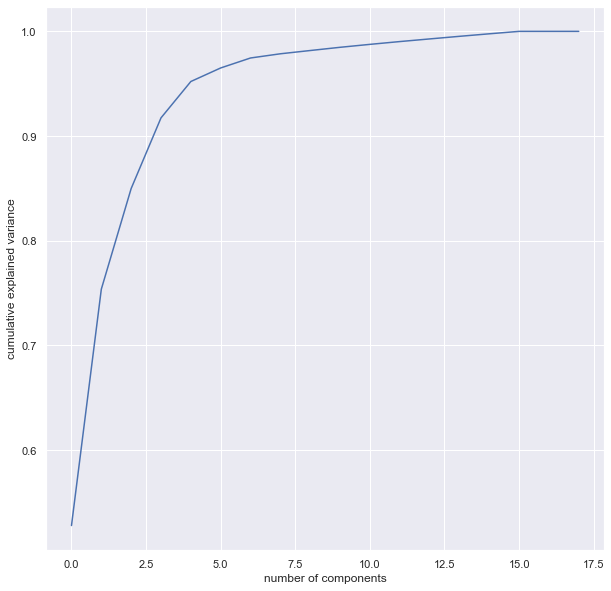

In [17]:
#Choose number of components
from sklearn.decomposition import PCA
pca = PCA().fit(df1)
plt.plot(np.cumsum(pca.explained_variance_ratio_)) #cumulative sum
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
np.cumsum(pca.explained_variance_ratio_)
#Only 4 components can explain over 90% o information

In [18]:
#4 principle components
pca = PCA(4)
Projected_df1 = pd.DataFrame(pca.fit_transform(df1),columns=['pc1','pc2','pc3','pc4'])
Projected_df1.head()

,pc1,pc2,pc3,pc4
0,7702.192871,441.208527,1881.179565,-667.311890
1,-2387.041992,-2788.541504,-2532.132324,-1589.011230
2,-4832.265137,-1092.642456,-2396.907471,-1815.934570
3,1971.656860,-2545.604980,-1252.417114,2578.419189
4,6051.730469,-1801.408569,-1133.380859,-1462.357422


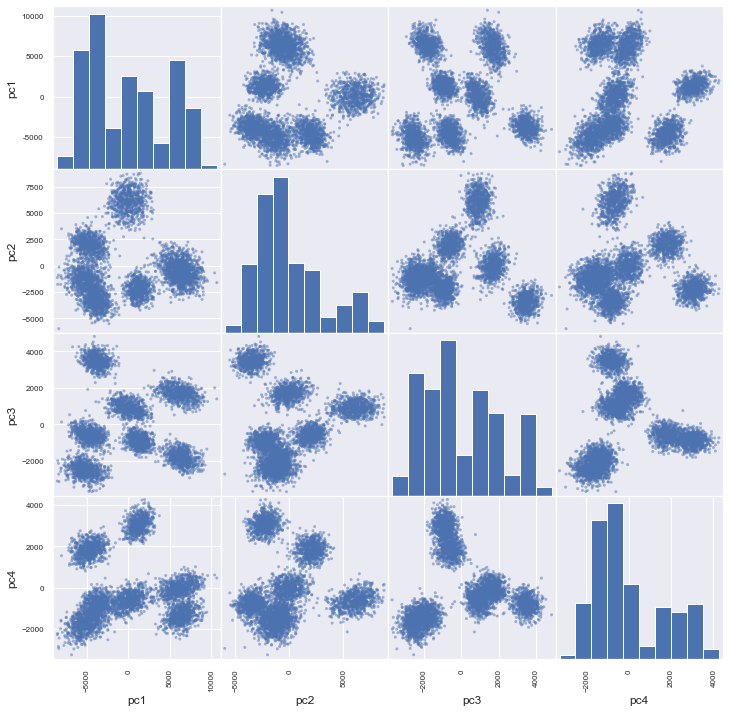

In [19]:
#Pairplot between principle components
from pandas.plotting import scatter_matrix
scatter_matrix(Projected_df1,figsize=(12,12))
plt.show()

In [20]:
#3d plot
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(Projected_df1['pc1'],Projected_df1['pc2'],Projected_df1['pc3'])

From the above plots, it is indicative that there are about 7 clusters formed by the principal components. Since the data points in the scatterplot give separable ellipses (2D) and ellipsoids (3D), we expect both **Gaussian Mixture Models**(distribution-based) and **K-means**(distance-based) can give ideal clusters, while density-based clustering model (**DBSCAN**) is not very necessary here because there's no obvious ring-shaped or other arbitrarily shaped clusters here.

We then use **GMM** and **K-means** to formally divide asteroids into groups containing similar mixure of minerals, and for each of these 2 models, we start by automatically deciding the number of clusters, then fit the model with the optimal cluster number, and finally give the centres and variations of each cluster.

### Gaussian Mixure Models

Text(0.5, 0, 'n_components')

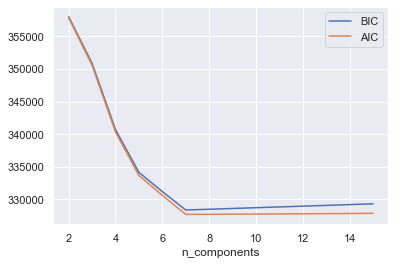

In [21]:
from sklearn.mixture import GaussianMixture
#How many clusters?
%matplotlib inline 
n_components = np.arange(2, 16)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Projected_df1)
for n in n_components]
#Bayesian Information criteria
plt.plot(n_components, [m.bic(Projected_df1) for m in models], label='BIC')
#Akaike information criterion
plt.plot(n_components, [m.aic(Projected_df1) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')\
#Both information criteria suggest 7 clusters

In [22]:
gmm = GaussianMixture(n_components = 7, covariance_type = 'full', tol = 0.001)
gmm = gmm.fit(X=Projected_df1)

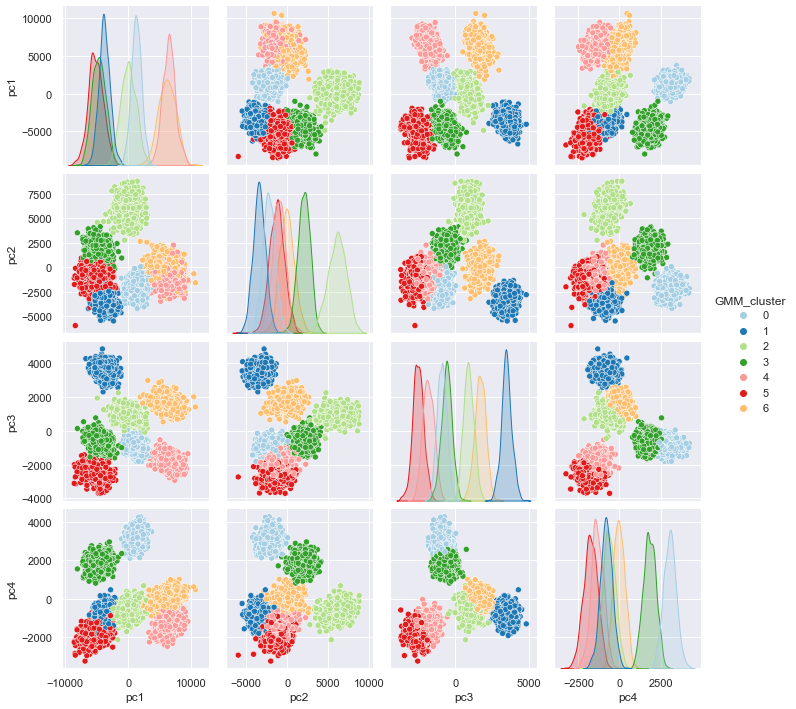

In [23]:
#Visualize clusters
labels = gmm.predict(Projected_df1)
Projected_df1['GMM_cluster'] = labels
sns.pairplot(data = Projected_df1, hue = 'GMM_cluster',palette = "Paired")
plt.show()

In [24]:
#3d plot
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(Projected_df1['pc1'],Projected_df1['pc2'],Projected_df1['pc3'],c=Projected_df1['GMM_cluster'])

From the scatterplots & kernel density estimations colored by cluster indexes, we can see how different clusters of asteroids differ from each other in terms of thier mixture of mineral principle components.

We then need to know:
- the typical(average) mixture of minerals for each type of asteroid
- the variation in mineral mixture between steroid types

However, we now only have the means and covariance matrixes of the clusters after PCA from the GMM. Fortunately, since the principle components are variables **affinely transformed** from the original features, the clusters transformed back in the original feature space are also multivariate normal distributed, and we can calculate their means and covariance matrixes by simple multiplications.

In [25]:
print(gmm.means_[0]) #center for cluster 0 after PCA

[ 1279.39248499 -2255.85190573  -919.16457443  3056.0979966 ]


In [26]:
mean_original = pca.inverse_transform(gmm.means_) #center for each cluster before PCA
center_gmm = pd.DataFrame(mean_original,columns = df1.columns)
center_gmm

,Alamosite,Chalcophyllite,Gypsum,Orpiment,Junitoite,Phoenicochroite,Groutite,Zykaite,Weloganite,Diadochite,Semseyite,Creedite,Xieite,Eveite,Rutile,Tyrolite,Feroxyhyte,Kostovite
0,2915.597714,4086.294278,2129.309646,2885.516919,4221.529101,2870.601466,13660.595457,4818.316133,2956.021309,4358.731238,3097.063078,8854.515091,4735.993647,2160.279990,3665.542263,4022.964915,4836.524704,3125.396755
1,4116.373480,4686.610964,4867.160292,1887.164097,4051.200125,2388.227370,18466.751490,4533.628052,1701.394883,2354.537564,2961.170835,5861.065467,2798.590759,4989.276485,2957.167769,3940.508454,4381.774352,2410.307941
2,4000.347658,1549.230991,2310.193811,4535.177695,2160.134109,3976.770611,18001.954857,2078.550133,3939.697247,2983.857739,3634.798365,13804.952347,2987.082616,4630.328995,2026.587618,2751.702744,2835.423878,3738.055843
3,4590.687510,2668.673537,1380.192860,3167.127413,3798.322833,3359.322704,20362.514033,3579.793486,2983.255761,4647.687652,2783.448920,9699.773422,4316.207197,2644.697209,2652.022446,3337.119683,4644.645878,2992.738905
4,1971.915181,4395.480020,3541.306269,3573.702655,3688.412112,2206.580118,9887.506613,2388.176478,5046.708639,3190.655100,3709.193118,10920.958086,3865.353691,3197.454516,2225.133780,2874.105180,1948.373869,3354.452505
5,4450.396676,4446.476194,2640.717145,2211.066679,5003.299651,1702.658633,19803.250585,2144.359723,4225.247437,4706.015446,2503.956391,6833.148349,4332.107165,2264.109370,1352.281216,2517.347334,3011.179282,2233.101099
6,2176.713765,3630.530170,4042.819589,3815.574503,2737.001835,3173.037641,10706.213404,3698.907663,3488.967495,2097.465072,3969.222178,11645.995703,3036.132457,4727.149282,3186.876036,3659.622252,3046.116677,3673.161332


Each row in the above table gives the typical(average) amount of minerals in one cluster outputted from **GMM**, in general, the means vary from cluster to cluster and there are some clusters having extremely low or high values of a particular mineral, for example, cluster 3 & 6 has a relatively small amount of Alamosite in their mixture of minerals.

In [27]:
print(gmm.covariances_[0]) #Covariance matrix for cluster 0 after pca for each cluster

[[625542.69278869  -2571.54900103 -53718.77547892  87631.98091645]
 [ -2571.54900103 536324.84565308  21269.95686272  38521.71959616]
 [-53718.77547892  21269.95686272 104406.79372142  -1733.03099046]
 [ 87631.98091645  38521.71959616  -1733.03099046 142284.20304826]]


In [28]:
#Covariance metrix before PCA
cov_original = [np.dot(np.dot(pca.components_.T ,gmm.covariances_[i]),pca.components_) for i in range(7)]
print(cov_original[0])

[[ 3.46324908e+04 -1.56685364e+04 -7.00428286e+03 -5.94214940e+03
   3.01353821e+02  3.90994045e+03  1.38561124e+05 -1.17739756e+04
  -1.05554817e+04  5.42249007e+03 -9.80677713e+03 -1.78199525e+04
  -7.32741560e+03  8.69760017e+03 -1.46024573e+04 -7.50261515e+03
   5.99269894e+03 -8.27883906e+03]
 [-1.56685364e+04  7.37462782e+04  4.56394313e+04 -4.66067073e+04
   4.59736388e+04 -4.63994943e+04 -6.26589283e+04  1.97899685e+04
  -6.11743118e+03 -9.75498229e+02 -1.05286569e+04 -1.39804259e+05
   8.24229181e+03 -1.54346697e+04  2.10101958e+03  8.03697369e+03
  -7.75669943e+02 -2.49664464e+04]
 [-7.00428286e+03  4.56394313e+04  5.12180185e+04 -2.90504909e+04
   1.96792018e+04 -2.88244328e+04 -2.79873536e+04  6.33062880e+03
  -8.58816724e+03 -2.21574888e+04 -2.81751245e+03 -8.71278494e+04
  -1.32973696e+04  1.79535221e+04 -3.85717922e+03  3.34869496e+03
  -1.05094987e+04 -1.60951179e+04]
 [-5.94214940e+03 -4.66067073e+04 -2.90504909e+04  3.83970641e+04
  -3.43961886e+04  3.08298531e+04 -2.

In [29]:
#Find standard deviation for each mineral in each cluster by selecting the diagonal elements in the covariances matrixes
dev_original = []
for i in range(7):
    dev_original.append([np.sqrt(cov_original[i][j][j]) for j in range(len(cov_original[i]))])#diagonal entries

std_gmm = pd.DataFrame(dev_original,columns = df1.columns)
std_gmm

,Alamosite,Chalcophyllite,Gypsum,Orpiment,Junitoite,Phoenicochroite,Groutite,Zykaite,Weloganite,Diadochite,Semseyite,Creedite,Xieite,Eveite,Rutile,Tyrolite,Feroxyhyte,Kostovite
0,186.098068,271.562660,226.313982,195.951688,189.878069,181.726890,744.559743,211.695278,174.362954,150.050542,84.481575,587.797826,126.661702,191.910478,153.112750,110.329631,184.001763,119.980732
1,212.801591,269.780347,231.525581,184.055367,185.782786,175.443459,851.375606,205.459196,175.105403,168.208175,87.783807,552.118768,137.651865,210.715221,150.145210,108.070538,181.419123,113.358924
2,273.985638,399.447757,303.507661,300.753129,273.288009,254.541588,1096.177317,221.128432,206.111337,165.563751,125.820346,902.171529,138.804155,210.690601,154.139293,111.794086,186.423413,181.809730
3,260.239632,278.072816,234.513734,183.609705,179.204061,177.196149,1041.168205,217.131782,192.666091,161.911144,94.552596,550.775372,135.220940,204.687632,164.715562,115.725092,192.287159,116.959162
4,245.172187,302.722594,247.861015,215.457598,204.653340,193.286969,980.890142,230.296605,206.864935,166.633788,99.446992,646.320832,138.552556,212.219827,164.007820,120.685884,198.669730,131.647245
5,276.990643,333.381916,274.821872,240.955979,226.934158,214.978199,1108.199613,238.625383,202.954380,179.615309,114.791700,722.796201,145.167003,219.286190,179.811863,125.789011,205.197618,151.278187
6,333.263092,329.333396,254.468305,214.484134,208.269480,197.589070,1333.322466,207.396836,190.006269,174.318097,117.207597,643.391039,144.104642,219.103995,168.391709,112.828069,169.111109,138.607370


Each row in the above table gives the degree of variation in the number of minerals in one cluster outputted from **GMM**, in general, the standard deviations of each mineral changed marginally compared with the changes in the means. The distinction of variances happens between features (different minerals) rather than between clusters.

### K-means 

In [30]:
#K-means is distance_based, we need standardiza the data 
from sklearn import preprocessing
Projected_df1 = Projected_df1.drop('GMM_cluster',axis=1)
Projected_df1 = Projected_df1.astype('float')
standardized_pc = preprocessing.scale(Projected_df1) #mean is 0, width matches a normal Gaussian distribution
standardized_pc = pd.DataFrame(standardized_pc,columns = Projected_df1.columns)

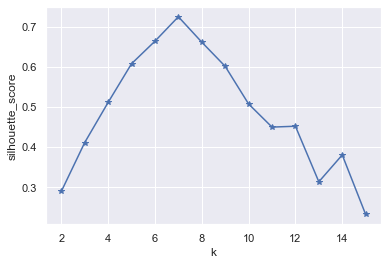

In [31]:
#Sihouette method
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import metrics
def k_silhouette(X, clusters):
    K = range(2, clusters+1)
    S = []
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        labels = kmeans.labels_
        S.append(metrics.silhouette_score(X, labels, metric='euclidean'))
    
    plt.plot(K,S,'b*-')
    plt.xlabel('k')
    plt.ylabel('silhouette_score')
    
    plt.show()
    
k_silhouette(standardized_pc, 15)
#7 clusters

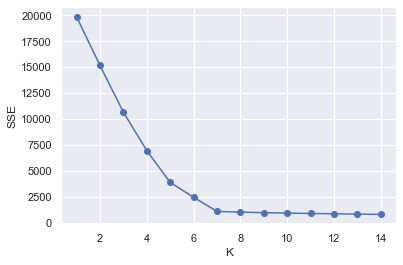

In [32]:
#Elbow Method
import matplotlib.pyplot as plt
sse = []
for k in range(1,15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(standardized_pc)
    sse.append(kmeans.inertia_) #sse
x = range(1,15)
plt.xlabel('K')
plt.ylabel('SSE')
plt.plot(x,sse,'o-')
plt.show()
#7 clusters

In [33]:
#7 clusters
kmeans = KMeans(n_clusters=7)
kmeans.fit(standardized_pc)
y_km = kmeans.fit_predict(standardized_pc)

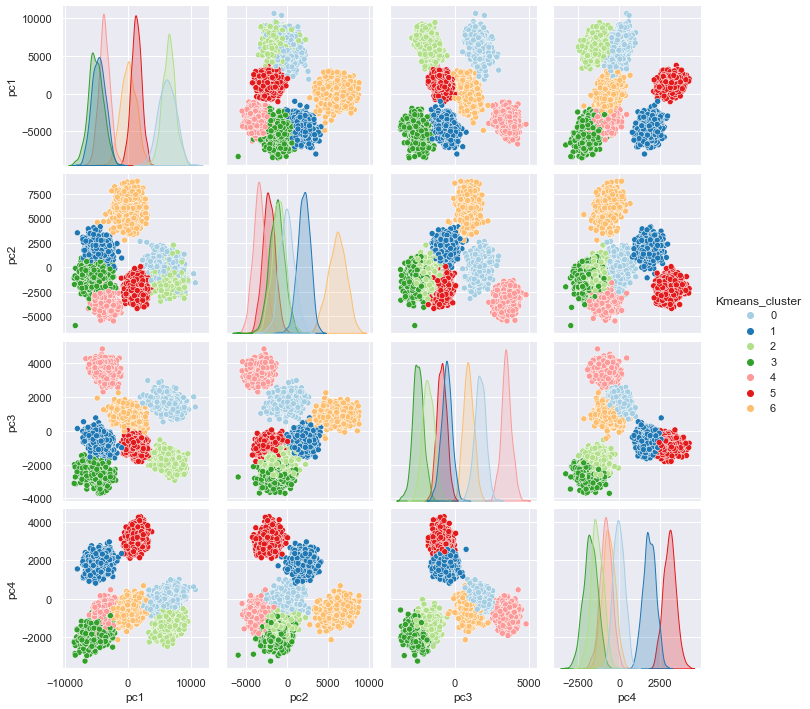

In [34]:
Projected_df1['Kmeans_cluster'] = y_km
sns.pairplot(data = Projected_df1,vars = ['pc1','pc2','pc3','pc4'], hue = 'Kmeans_cluster',palette = "Paired")
plt.show()

In [35]:
#3d plot
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111,projection='3d')
ax.scatter(Projected_df1['pc1'],Projected_df1['pc2'],Projected_df1['pc3'],c=Projected_df1['Kmeans_cluster'])

Before looking at the statistics for the mean and variance of the cluters from **K-means**, we can compare the above plots with the ones from **KMM** and they look perfectly similar in the principle component space. However, we need to compare them in a more sophisticated way.

In [36]:
#average mixure of minerals for each cluster
center_original = pca.inverse_transform(kmeans.cluster_centers_)
center_kmeans = pd.DataFrame(center_original,columns = df1.columns)
center_kmeans

,Alamosite,Chalcophyllite,Gypsum,Orpiment,Junitoite,Phoenicochroite,Groutite,Zykaite,Weloganite,Diadochite,Semseyite,Creedite,Xieite,Eveite,Rutile,Tyrolite,Feroxyhyte,Kostovite
0,3469.489534,3641.608006,2988.005687,3149.283880,3673.541723,2800.529519,15878.076169,3297.341725,3491.925289,3483.402887,3232.422177,9647.069184,3724.923466,3511.231882,2562.013166,3287.478937,3512.838219,3068.836157
1,3469.992580,3641.264828,2986.910891,3149.228290,3673.853544,2800.661608,15880.088019,3297.410666,3491.900785,3484.363534,3232.113234,9646.901924,3725.533785,3510.291160,2562.003030,3287.435004,3513.393267,3068.746157
2,3469.421072,3641.948407,2987.759977,3149.188658,3673.989901,2800.050322,15877.802648,3296.595366,3492.748570,3483.932734,3232.295918,9646.783861,3725.305010,3510.506639,2561.470006,3287.040169,3512.222481,3068.678736
3,3469.947649,3642.004603,2987.562779,3148.884612,3674.321266,2799.875589,15879.909423,3296.426504,3492.683667,3484.302475,3232.025139,9645.871814,3725.432676,3510.243198,2561.197278,3286.897981,3512.347665,3068.415862
4,3469.893570,3641.976200,2988.541516,3148.769261,3673.798865,2800.301652,15879.692909,3297.595939,3491.392655,3483.188022,3232.232846,9645.525524,3724.674287,3511.594673,2561.982551,3287.592833,3513.092620,3068.518996
5,3469.581432,3641.678094,2986.966566,3149.074053,3674.066573,2800.544692,15878.442826,3297.951262,3491.760713,3484.440504,3232.136524,9646.438926,3725.778489,3509.980782,2562.399242,3287.713013,3513.681048,3068.752494
6,3469.936116,3640.967776,2987.504458,3149.590473,3673.317010,2800.754682,15879.862879,3296.697443,3492.235439,3483.632230,3232.375257,9647.989088,3724.893265,3511.212332,2561.591197,3287.132220,3512.589527,3068.901501


Each row in the above table gives the typical(average) amount of minerals in one cluster outputted from **K-means**, surprisingly, there is nearly no difference between the typical amount of mixure of minerals between clusters.

In [37]:
#standard deviations for each mineral in each cluster
df1['kmeans_cluster'] = y_km
std_kmeans = pd.DataFrame(df1.groupby('kmeans_cluster').std())
df1 = df1.drop('kmeans_cluster',axis=1)
std_kmeans 

,Alamosite,Chalcophyllite,Gypsum,Orpiment,Junitoite,Phoenicochroite,Groutite,Zykaite,Weloganite,Diadochite,Semseyite,Creedite,Xieite,Eveite,Rutile,Tyrolite,Feroxyhyte,Kostovite
kmeans_cluster,,,,,,,,,,,,,,,,,,
0,356.564365,275.277020,279.367237,306.592979,280.810984,269.249623,1426.793198,332.687976,366.204304,341.854198,247.378648,919.645984,350.473162,382.302486,245.152985,224.635838,245.461354,249.953743
1,277.023722,311.021647,244.412629,257.840199,222.540291,352.832419,1108.080577,356.365512,294.087684,423.361824,407.190958,771.764441,424.327908,236.683851,440.216463,289.531894,360.070125,448.111561
2,261.112433,333.293041,300.570867,304.871076,311.949805,255.219974,1044.550094,354.979419,362.970961,367.760853,415.356599,913.359324,206.010212,395.791939,312.331621,443.351020,364.362906,291.293349
3,295.361292,213.914344,341.436288,344.416349,312.384946,346.154331,1180.095130,356.666695,341.941229,440.827023,235.545867,1032.815120,344.401413,316.884308,394.243937,213.789851,447.119207,379.901384
4,226.674646,327.298895,257.602182,260.952580,416.159537,417.227597,907.121681,214.866850,286.168618,387.512537,428.467876,782.875835,383.757902,379.765860,420.557459,286.907450,377.882295,199.721526
5,198.055352,400.998850,312.801480,271.088352,350.369483,274.583377,792.928688,380.944503,253.774169,272.774994,263.427160,813.367532,380.682140,324.318560,196.558546,384.880085,424.168606,275.642059
6,290.860421,382.087379,324.767485,430.577826,250.942572,241.662906,1162.458269,329.872907,238.172202,309.198960,397.742666,1291.975268,417.404610,350.590059,252.282916,227.136117,398.479219,323.639779


Each row in the above table gives the degree of variation in the number of minerals in one cluster outputted from **K-means**. Different from the means, standard deviations seem varied from cluster to cluster, even more significantly than the variations between **GMM** clusters in most circumstances.

### Summary for task 1

In the first part of the analysis, we aim to divide asteroids into different groups based on thier mixure of 18 minerals. We first apply **PCA** on the original dataset, then used 2 unsurpervised clustering algorithms (**GMM** & **K-means**) to realize the analysis. These are the major findings:

- No matter whether based on information criteria for **GMM** or using the elbow and Sihouette method for **K-means**, the optimal number of clusters is always 7.
- Observed from the scatterplots coloured by the output clusters after **PCA**, it seems tempting that the results these 2 algorithms give are similar.
- When projected back to the original feature space, we find that the typical amount of mixture of minerals varies between **GMM** clusters but remains unchanged in the **K-means** case.
- As for the variations in the mineral mixture between asteroid types, we calculated the standard deviation for each mineral in each cluster and in both models, they changes between asteroid types.

## Task 2 -- Find inferring rule for mechanically stable asteroids

### Load and Clean data

In [38]:
df2 = pd.read_csv('China Aug 2022 Asteroid 2 V4.csv')# read the dataset
df2.head()

,Chalcophyllite,Gypsum,Orpiment,Junitoite,Phoenicochroite,Groutite,Zykaite,Weloganite,Diadochite,Category
0,218,490,25,184.0,316,823,115,325,3711,1
1,731,720,436,183.0,66,778,31,557,4613,0
2,950,964,300,912.0,601,188,114,556,1336,0
3,833,568,255,893.0,638,859,681,749,1836,0
4,938,904,328,992.0,795,602,965,928,3381,0


In [39]:
#Data types
df2.dtypes

Chalcophyllite      object
Gypsum              object
Orpiment            object
Junitoite          float64
Phoenicochroite     object
Groutite            object
Zykaite             object
Weloganite          object
Diadochite          object
Category            object
dtype: object

In [40]:
#Convert to numerical value
#‘coerce’means invalid parsing(eg.str) will be set as NaN.
df2 = df2.apply(pd.to_numeric, downcast='float', errors='coerce')

In [41]:
df2.isnull().sum(axis=0)

Chalcophyllite      6
Gypsum              7
Orpiment           11
Junitoite           0
Phoenicochroite     8
Groutite            5
Zykaite             5
Weloganite          5
Diadochite          6
Category            6
dtype: int64

In [42]:
df2.describe()

,Chalcophyllite,Gypsum,Orpiment,Junitoite,Phoenicochroite,Groutite,Zykaite,Weloganite,Diadochite,Category
count,1.107000e+03,1.106000e+03,1.102000e+03,1.113000e+03,1.105000e+03,1.108000e+03,1.108000e+03,1.108000e+03,1.107000e+03,1.107000e+03
mean,1.419286e+03,5.917221e+03,1.412263e+03,3.981014e+03,1.112932e+04,1.731063e+04,5.917677e+03,9.134546e+03,3.904219e+03,5.423943e+03
std,3.005986e+04,7.350983e+04,3.013441e+04,5.808516e+04,2.681026e+05,2.786175e+05,7.344024e+04,1.524902e+05,3.004004e+04,7.350489e+04
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00
25%,2.765000e+02,2.525000e+02,2.635000e+02,2.520000e+02,2.660000e+02,2.607500e+02,2.545000e+02,2.530000e+02,1.430500e+03,0.000000e+00
50%,5.260000e+02,4.980000e+02,5.000000e+02,4.870000e+02,4.990000e+02,5.170000e+02,5.105000e+02,5.025000e+02,3.003000e+03,0.000000e+00
75%,7.645000e+02,7.345000e+02,7.457500e+02,7.540000e+02,7.550000e+02,7.492500e+02,7.470000e+02,7.500000e+02,4.615500e+03,0.000000e+00
max,1.000611e+06,1.000876e+06,1.000813e+06,1.000749e+06,8.745635e+06,8.745635e+06,1.000870e+06,4.563545e+06,1.000744e+06,1.000843e+06


Similar to the previous dataset, there are several extremely large outliers, we replace them with NaNs and impute together with the original missing values. However, one thing we need to keep in mind is that the 'Category' column contains only 0 or 1, so extra attention should be paid to this column.

In [43]:
#replace outliers with NaN
for column in df2.columns:
    #values larger than mean + 3* standard deviation
    outliers_index = df2[df2[column] > np.mean(df2[column])+3 * np.std(df2[column])].index
    df2.loc[outliers_index,column] = np.nan

In [44]:
df2.describe()
#There's still some anomalous instances in 'Junitoite' & 'Groutite' columns

,Chalcophyllite,Gypsum,Orpiment,Junitoite,Phoenicochroite,Groutite,Zykaite,Weloganite,Diadochite,Category
count,1106.000000,1100.000000,1101.000000,1109.000000,1101.000000,1097.000000,1102.000000,1102.000000,1106.000000,1101.000000
mean,515.858032,490.655457,504.542236,499.749329,499.436890,503.862366,501.166962,502.529053,3002.916748,0.144414
std,284.584595,283.425049,284.985260,292.547180,288.429779,283.343170,287.473022,287.604736,1772.149414,0.351671
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,7.000000,0.000000
25%,276.250000,251.500000,263.000000,252.000000,264.000000,258.000000,253.000000,252.250000,1427.750000,0.000000
50%,525.000000,495.000000,500.000000,486.000000,495.000000,509.000000,509.500000,499.500000,2997.000000,0.000000
75%,764.000000,730.250000,745.000000,752.000000,752.000000,741.000000,744.000000,748.750000,4609.500000,0.000000
max,1000.000000,999.000000,1000.000000,1000.000000,999.000000,999.000000,999.000000,998.000000,5985.000000,1.000000


In [45]:
df2.isnull().sum(axis=0)

Chalcophyllite      7
Gypsum             13
Orpiment           12
Junitoite           4
Phoenicochroite    12
Groutite           16
Zykaite            11
Weloganite         11
Diadochite          7
Category           12
dtype: int64

In [46]:
#impute NaNs using KNN
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3) #using 3 most similar data points
df2 = pd.DataFrame(imputer.fit_transform(df2),columns = df2.columns)

In [47]:
#transform inputed value in the 'category' column to 0 or 1
df2['Category'] = df2['Category'].apply(lambda x: 0 if x < 0.5 else 1) 
df2['Category'] = df2['Category'].astype('int')
df2['Category'].unique()

array([1, 0])

In [48]:
df2.isnull().sum().sum() #No missing values anymore

0

(10.5, -0.5)

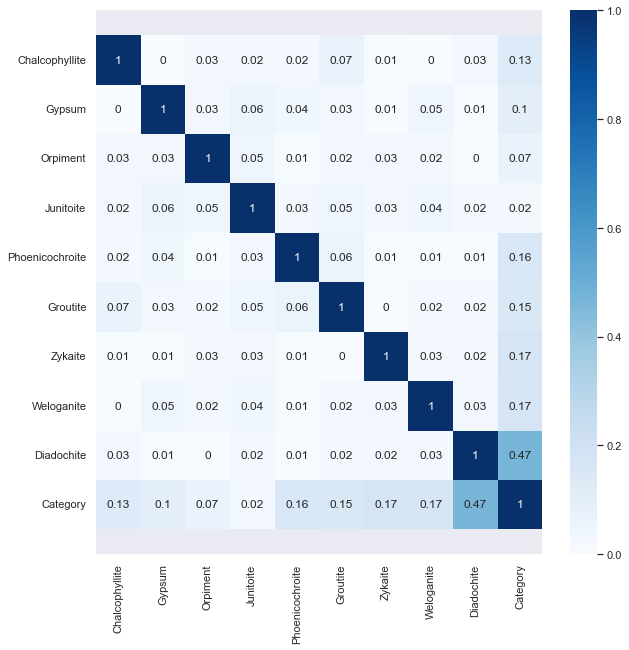

In [49]:
#correlation
%matplotlib inline
correlation_matrix = np.absolute(df2.corr().round(2))
sns.set(rc={'figure.figsize':(10,10)})
ax = sns.heatmap(correlation_matrix,annot=True, cmap='Blues')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

From the above plot, we find that most of the features are almost uncorrelated with another feature or the target category, so there is no need for dimensionality reduction. The only exception is the correlation between Diadochite and the label.

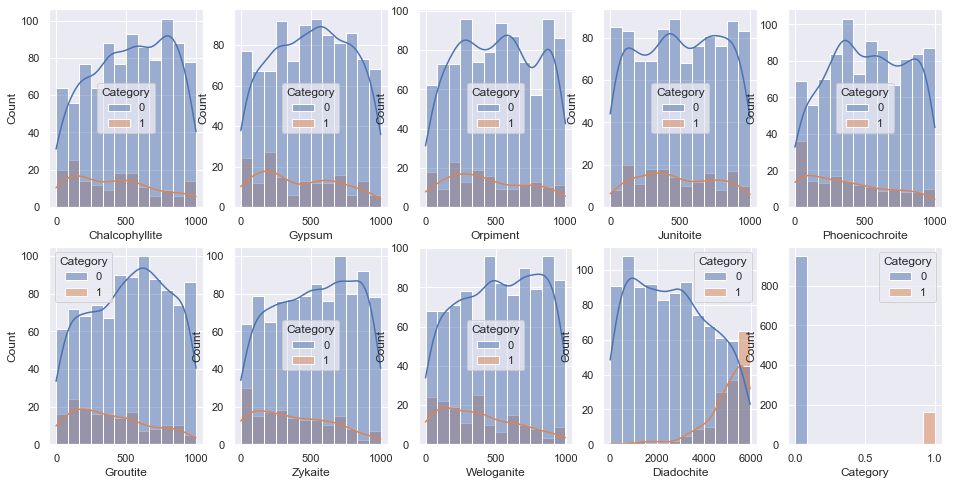

In [50]:
#Distribution of each minerals group by stable type of the asteroid
fig,axes=plt.subplots(2,5,figsize = (16,8))
for i, col in enumerate(df2.columns):
    if i < 5:
        sns.histplot(df2, x=col, hue="Category", kde=True,ax = axes[0,i])
    else:
        sns.histplot(df2, x=col, hue="Category", kde=True,ax = axes[1,i-5])
#Unstable asteroids generally have high concentration of  Diadochite

From the count plot of the number of instances we have for 2 categories, the problem of **Imbalanced Data** is obvious. Specifically, we only have less than 200 instances having the label 1 (not stabel).

With imbalanced dataset, the algorithm learns that a given class is more common, making it “natural” for there to be a greater tendency towards it, so is then prone to overfitting the majority class. Just by predicting the majority class, models would score high on their loss-functions. In these instances, the **Accuracy Paradox** appears. Hence, in this situation, accuracy is not an ideal metric to quantify performances of the models. 

We need to apply some techniques to alleviate or circumvent this shortcoming. The following methods are used in a combined manner in the following analysis:

- Using more insightful performance metrics: Confusion Metrix, F-Score, ROC curve and ect.
- Try different algorithms: Logistic Regression, Random Forest, Artificial Neural Networks and ect.
- Use *penalized classification*: imposes an additional cost on the model for making classification mistakes on the minority class during training.
- Apply *threshold-moving*：Tuning or shifting the decision threshold in order to accommodate the broader requirements of the classification problem.

Apart from these methods, we can also try over-sampling the rare class' instances or under-sampling the over-represented ones. Alternatively, we can simply regard the problem as an anomaly detection or change detection problem.

We now standardize the dataset and try to integrate the aforementioned 'tricks' into our model construction.

In [51]:
#Standardize data
X,Y = df2.loc[:,'Chalcophyllite':'Diadochite'], df2['Category']
from sklearn import preprocessing
X = X.astype('float')
standardized_x = preprocessing.scale(X)
standardized_x = pd.DataFrame(standardized_x,columns = X.columns)

In [52]:
#Split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(standardized_x, Y, test_size =0.3,random_state = 6)

### Logistic Regression with optimized threshold

A simple and straightforward approach to improving the performance of a classifier that predicts probabilities on an **imbalanced classification problem** is to tune the threshold used to map probabilities to class labels. 

First, we use the default threshold (0.5) to train a **Logistic Regression** classifier and measure its performance using confusion matrix. Then, we seek for the best threshold according to **F1-score** and see if there's any improvement in its performance. (The **F1-score** is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model’s precision and recall.)

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score, precision_recall_curve

In [54]:
#Without optimized threhold
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(confusion_matrix(y_pred, y_test))
print('Precision = ', precision_score(y_pred, y_test))
print('Recall = ', recall_score(y_pred, y_test))

[[281   8]
 [  3  42]]
Precision =  0.84
Recall =  0.9333333333333333


This confusion matrix shows that 8 mechanically stable asteroids have been misclassified as unstable ones and 3 asteroids in the other way around. This result is not depressing for a simple classification algorithm like **logistic regression**, but we still try to optimize the threshold according to highest **F1-score** on training dataset and see if there will be any improvement.

In [55]:
#Choose the optimal threhold with highest F1-score
class LogisticRegressionWithThreshold(LogisticRegression):
    def predict(self, X, threshold=None):
        if threshold == None: # If no threshold passed in, simply call the base class predict, effectively threshold=0.5
            return LogisticRegression.predict(self, X)
        else:
            y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
            y_pred_with_threshold = (y_scores >= threshold).astype(int)
            return y_pred_with_threshold

    def threshold_from_optimal_f_score(self, X, y):
        y_scores = LogisticRegression.predict_proba(self, X)[:, 1]
        precisions, recalls, thresholds = precision_recall_curve(y, y_scores)
        fscores = (2 * precisions * recalls) / (precisions + recalls) # F1 Score        
        optimal_idx = np.argmax(fscores)        
        return thresholds[optimal_idx], fscores[optimal_idx]

In [56]:
lrt = LogisticRegressionWithThreshold()
lrt.fit(X_train, y_train)

LogisticRegressionWithThreshold()

In [57]:
threshold, optimal_f_score = lrt.threshold_from_optimal_f_score(X_train, y_train)
y_pred = lrt.predict(X_train, threshold)
print('The optimal threshold = ', threshold)
print('The optimal F1-score = ', optimal_f_score)

The optimal threshold =  0.45504484136716755
The optimal F1-score =  0.8949771689497716


In [58]:
y_pred = lrt.predict(X_test, threshold)
print(confusion_matrix(y_pred, y_test))
print('Precision = ', precision_score(y_pred, y_test))
print('Recall = ', recall_score(y_pred, y_test))

[[278   6]
 [  6  44]]
Precision =  0.88
Recall =  0.88


Using LogisticRegressionWithThreshold class defined in this section, the optimal threshold is calculated to be about 0.455. That means whenever the output probability is larger than 0.455, the corresponding asteroid will be classified as mechanically unstable.

While the accuracy of the model remains nearly unchanged, the precision has been improved while the recall falls. Although this result fails to fulfil our expectation that with an optimized threshold, we can reduce the number of misclassifying the minor class, we cannot conclude that threshold-moving is useless here. We might need to change the criteria or the way the test data are split, and trying to perform a k-fold cross-validation may gives more accurate performance measurements.

###  Randon forest  in a cost-sensitive approach

**Decision Trees** often perform well on imbalanced datasets, since the splitting rules that look at classes variable used in the creation of decision trees can force both classes to be addressed.

We will start with using a **random forest** with its hyper-parameters optimized by grid research and then repeat the process while assigning a high cost to misclassification of the minority class using the class weight parameter.

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()

In [60]:
#Hyper-parameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'ccp_alpha':[0.0, 0.005,0.006, 0.007,0.008,0.009, 0.01],
     'criterion':['gini','entropy'],
     'max_depth':[4,5,6,7,8,9,10],
     'max_leaf_nodes':[8,10,12,14,16,18]}
]

In [61]:
clf = GridSearchCV(estimator=rfc,param_grid = param_grid)
best_model = clf.fit(X_train,y_train)

In [62]:
clf.best_estimator_

RandomForestClassifier(ccp_alpha=0.008, criterion='entropy', max_depth=10,
                       max_leaf_nodes=18)

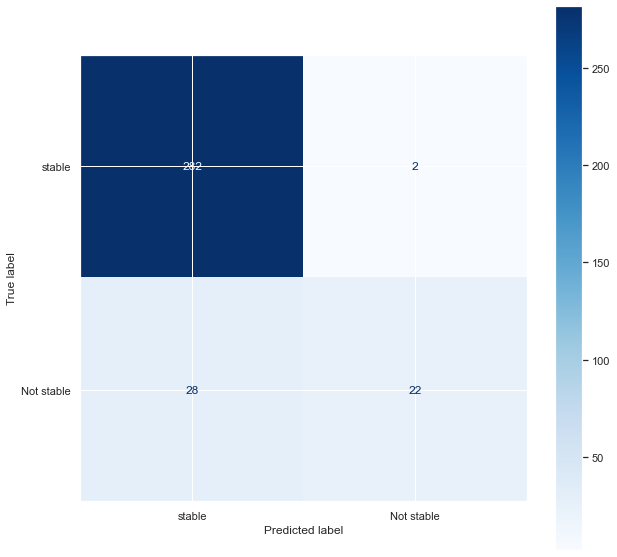

In [63]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(best_model, X_test, y_test, display_labels=['stable','Not stable'], cmap=plt.cm.Blues)
plt.show()

The above confusion metrix represents what we are worrying about: more than half of the unstable cases have been classified as stable ones, which is even worse than just randomly allocating an asteroid as stable or not!

Then, we try to weight 2 classes using 'class_weight' parameter in RandomForestClassifier(). More details: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [64]:
#Penalized classification
#Hyper-parameter tuning
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'ccp_alpha':[0.0, 0.005,0.006, 0.007,0.008,0.009, 0.01],
     'criterion':['gini','entropy'],
     'max_depth':[4,5,6,7,8,9,10],
     'max_leaf_nodes':[8,10,12,14,16,18],
     'class_weight':['balanced','balanced_subsample']}
]
#The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data 
#The “balanced_subsample” mode is the same as “balanced” except that weights are computed based on the bootstrap sample for every tree grown.

In [65]:
clf = GridSearchCV(estimator=rfc,param_grid = param_grid)
best_model_balanced = clf.fit(X_train,y_train)

In [66]:
clf.best_estimator_

RandomForestClassifier(ccp_alpha=0.008, class_weight='balanced_subsample',
                       criterion='entropy', max_depth=10, max_leaf_nodes=18)

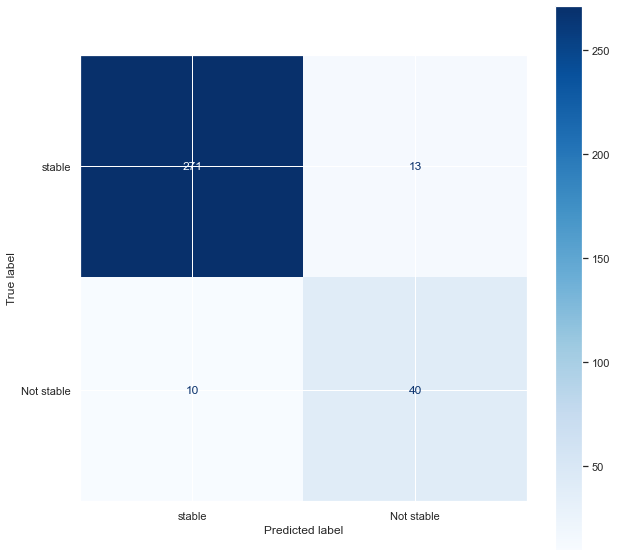

In [67]:
plot_confusion_matrix(best_model_balanced, X_test, y_test, display_labels=['stable','Not stable'], cmap=plt.cm.Blues)
plt.show()

Penalized classification works very well in this case, making the random forest classifier more competent at correctly figuring out unstable asteroids. At the same time, it is worth noticing that the proportion of accurately classified asteroids (Accuracy) hasn't improved a lot, but we can still safely conclude that the classifier is improved.

In [68]:
# Visualize one tree in the random forest
import os
from sklearn.tree import export_graphviz

# add Graphviz install path to the environment
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'

estimator = clf.best_estimator_.estimators_[3]  #the fourth tree, say
export_graphviz(estimator,out_file='tree.dot',
                feature_names=standardized_x.columns,
                class_names=['stable','not stable'],
                rounded=True,proportion=False,
                precision=2,filled=True)

In [69]:
from subprocess import call
call(['dot','-Tpng','tree.dot','-o','tree.png','-Gdpi=600']);

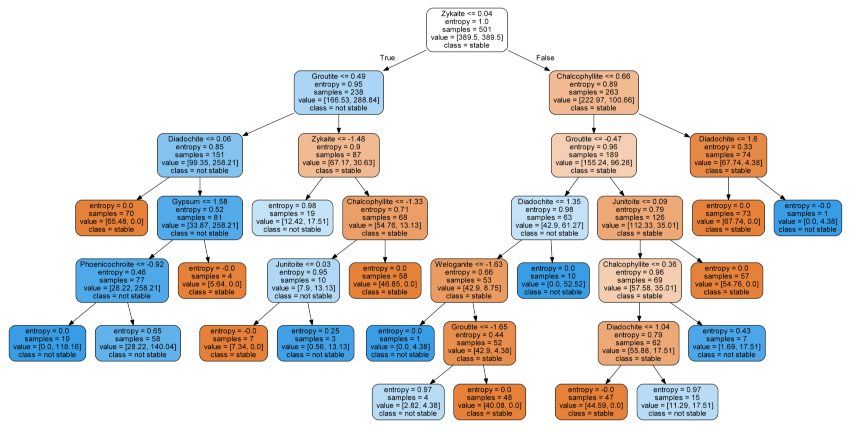

In [70]:
plt.figure(figsize = (15,15))
plt.imshow(plt.imread('tree.png'))
plt.axis('off');
plt.show()

### Artificial Neural Network 
In this section, we train an **ANN** to predict if an asteroid is mechanically stable based on its mixture of minerals. 

To alleviate the negative impacts the **imbalanced dataset** might bring to the model and avoid overfitting, we implore a class weight on the loss function, drop out 10% of connections between 2 layers of the network, use **AUPRC**(area under the precision-recall curve) as a performance measure, and reduce learning rate or stop learning when there's no improvement in the loss on the test dataset in several consecutive epochs.

Starting with a large learning rate and gradually reducing it during the training process can speed up the process while avoiding over-shooting, we realize this using ReduceLROnPlateau (Documentation: https://keras.io/api/callbacks/reduce_lr_on_plateau/ )

Stopping the training process before the network is overfitting on the training data is essential to guarantee the model's ability to generalize on unseen dataset, we realize this using EarlyStopping (Documentation: https://keras.io/api/callbacks/early_stopping/)

In [71]:
import math
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

In [72]:
#hidden nodes' number
feature_num = X_train.shape[1]  
start_node = 2**(math.ceil(math.log(feature_num/2,2)))  # node number for the first layer
print(start_node)

8


In [73]:
#class weights
normal_label_multiple = int(len(y_train[y_train==0])/len(y_train[y_train==1]))  # 只取整数部分
print("normal_label_multiple:{}".format(normal_label_multiple))
class_weight = {0:1,1:normal_label_multiple}

normal_label_multiple:5


In [74]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.1,seed=2), 
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])


model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=tf.keras.metrics.AUC(name='prc', curve='PR'))
              #AUPRC: area under presition-recall curve

#reduce learning rate when there is no improvement in validation loss for consecutive epoches
reduce_lr = ReduceLROnPlateau(monitor='val_loss',  
                              factor=0.1,  # new_lr = lr * factor
                              patience=5,
                              verbose=True,  
                              min_lr=1e-6  # minimun learning rate
                              )

#stop the training when there is no improvement in the validation loss for ten consecutive epochs.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train,
                    batch_size=16, 
                    epochs=100, 
                    validation_data=(X_test, y_test), 
                    validation_freq=1,
                    callbacks=[reduce_lr,early_stopping],
                    shuffle=True,
                    class_weight=class_weight)
model.summary()

Epoch 1/100
49/49 [==============================] - 2s 12ms/step - loss: 1.2390 - prc: 0.1500 - val_loss: 0.6007 - val_prc: 0.2819 - lr: 0.0010
Epoch 2/100
49/49 [==============================] - 0s 7ms/step - loss: 1.1243 - prc: 0.2109 - val_loss: 0.6051 - val_prc: 0.3588 - lr: 0.0010
Epoch 3/100
49/49 [==============================] - 0s 7ms/step - loss: 1.0753 - prc: 0.2696 - val_loss: 0.6045 - val_prc: 0.3883 - lr: 0.0010
Epoch 4/100
49/49 [==============================] - 0s 7ms/step - loss: 1.0288 - prc: 0.3723 - val_loss: 0.5981 - val_prc: 0.4231 - lr: 0.0010
Epoch 5/100
49/49 [==============================] - 0s 7ms/step - loss: 0.9808 - prc: 0.4363 - val_loss: 0.5901 - val_prc: 0.4702 - lr: 0.0010
Epoch 6/100
49/49 [==============================] - 0s 8ms/step - loss: 0.9267 - prc: 0.5145 - val_loss: 0.5757 - val_prc: 0.5196 - lr: 0.0010
Epoch 7/100
49/49 [==============================] - 0s 8ms/step - loss: 0.8657 - prc: 0.5743 - val_loss: 0.5478 - val_prc: 0.5754 - lr

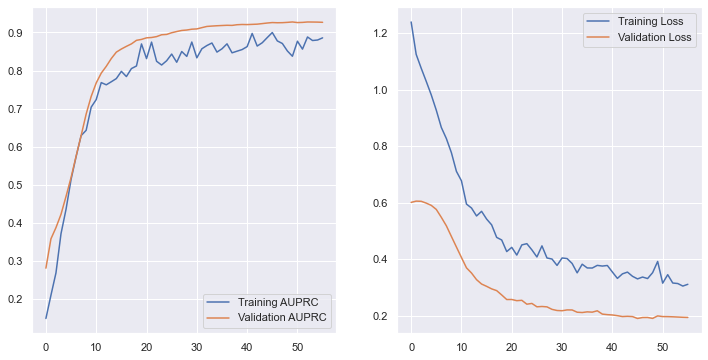

In [75]:
#Visualizing the loss and AUPRC
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12, 6))

ax1.plot(history.history['prc'], label='Training AUPRC')
ax1.plot(history.history['val_prc'], label='Validation AUPRC')
ax1.legend()

ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.legend()
plt.show()

From the above performance vs epochs plots, we can see that the model performs better on the validation set, which might be because regularization methods such as dropout are not applied at validation time, or because validation metrics are computed over the validation set only once the current training epoch is completed, or simply because the validation set may be easier than the training set. 

### Summary for task 2

In the second part of the analysis, we used **Logistic Regression**, **Random Forest**, and **Artificial Neural Networks** to predict if an asteroid is mechanically stable based on its mixture of minerals. We also integrated various techniques such as threshold-moving and penalized classification to combat potential problems brought by an imbalanced dataset.

## References

The methods used to deal with imbalanced data are learnt from: 
- https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
- https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
- https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/